# Домашнее задание 5. Линейные модели

In [314]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [315]:
data = np.load("files/out_4.dat.npz")
users = data["users"]
X = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [316]:
TRAINING_SET_URL = "/Users/anokhin/Desktop/twitter_train.txt"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["user_id", "class"], dtype={"user_id": str, "class": int})
df_users.set_index("user_id", inplace=True)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой. (Этого бы не пришлось делать, если бы мы в 4 домашке сохранили целевую -- надо учесть на будущее).

In [317]:
Y = df_users.ix[users.astype(str)]["class"].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (8000x833942) feature matrix, 8000 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа.

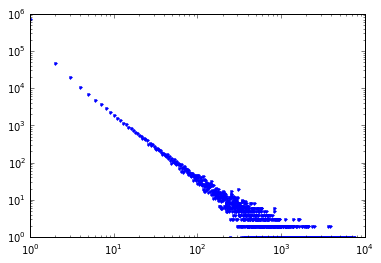

In [318]:
col_counts = np.diff(X.tocsc().indptr)

bin_counts = np.bincount(col_counts)
pl.plot(np.arange(bin_counts.shape[0]), bin_counts, ".")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [319]:
X1 = X.tocsc()[:, col_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [320]:
USER_NAME = "n.anokhin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [321]:
class LogisticRegression():
    
    def fit(self, X, Y=None):
        return self
    
    def predict_proba(self, X):
        import numpy.random as nr
        return nr.random((X.shape[0], 2))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [322]:
def auroc(y_prob, y_true):
    return 0.5

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [323]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
skf = cv.StratifiedKFold(Y, len(C))
for i, (train, test) in enumerate(skf):
    X_train, Y_train = X1[train], Y[train]
    X_test, Y_test = X1[test], Y[test]
    model = LogisticRegression().fit(X_train, Y_train)
    print i, auroc(model.predict_proba(X_test)[:, 0], Y_test)

0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.503911


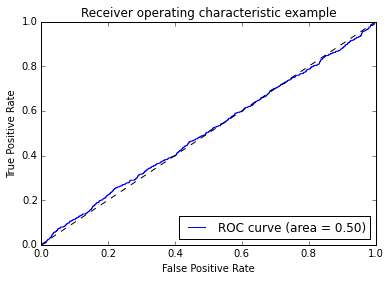

In [324]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X1, Y, test_size=0.3)
Y_prob = LogisticRegression().fit(X_train, Y_train).predict_proba(X_test)
fpr, tpr, thresholds = sm.roc_curve(Y_test, Y_prob[:, 1])
roc_auc = sm.auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате.